Train shape: (38544, 24, 27)  Test shape: (9636, 24, 27)
Epoch 1/15
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 50s 42ms/step - loss: 0.0393 - val_loss: 0.0054
Epoch 2/15
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 46s 42ms/step - loss: 0.0087 - val_loss: 0.0038
Epoch 3/15
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 81s 42ms/step - loss: 0.0076 - val_loss: 0.0042
Epoch 4/15
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 81s 40ms/step - loss: 0.0067 - val_loss: 0.0038
Epoch 5/15
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 83s 42ms/step - loss: 0.0064 - val_loss: 0.0051
Epoch 6/15
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 81s 41ms/step - loss: 0.0064 - val_loss: 0.0039
Epoch 7/15
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 84s 43ms/step - loss: 0.0062 - val_loss: 0.0029
Epoch 8/15
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 81s 42ms/step - loss: 0.0060 - val_loss: 0.0030
Epoch 9/15
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 82s 42ms/step - loss: 0.0053 - val_loss: 0.0038
Epoch 10/15
1085/1085 ━━━━━━━━━━━━━━━━━━━━ 82s 42ms/step - loss: 0.0055 - val_loss: 0.0029
Epoch 11/15
1085/1085 ━━━━━━━━━━━━━━━━━━━━

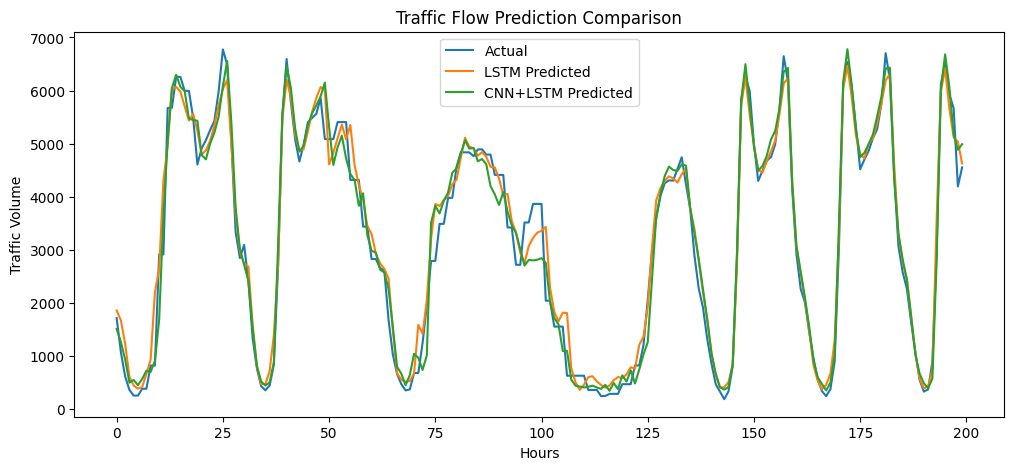

In [2]:
!pip install tensorflow pandas matplotlib scikit-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Input

# Load dataset
df = pd.read_csv("Metro_Interstate_Traffic_Volume.csv")

df['date_time'] = pd.to_datetime(df['date_time'])
df = df.sort_values('date_time')

# Extract time features
df['hour'] = df['date_time'].dt.hour
df['dayofweek'] = df['date_time'].dt.dayofweek

# One-hot encode categorical features
df = pd.get_dummies(df, columns=['holiday', 'weather_main'], drop_first=True)

# Drop unused text columns
df = df.drop(columns=['weather_description', 'date_time'])

# Normalize all features
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

# Sequence generator
def create_sequences(data, time_steps=24):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps])
        y.append(data[i+time_steps, list(df.columns).index('traffic_volume')])
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_data, time_steps=24)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

print("Train shape:", X_train.shape, " Test shape:", X_test.shape)

# ------------------ LSTM MODEL ------------------
model_lstm = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(256, return_sequences=True),
    Dropout(0.2),
    LSTM(128),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(1)
])

model_lstm.compile(optimizer='adam', loss='mse')

history_lstm = model_lstm.fit(X_train, y_train,
                              epochs=30,
                              batch_size=32,
                              validation_split=0.1,
                              verbose=1)


# ------------------ CNN+LSTM MODEL ------------------
model_cnn_lstm = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    LSTM(64, return_sequences=True),
    Dropout(0.2),
    LSTM(32),
    Dense(1)
])

model_cnn_lstm.compile(optimizer='adam', loss='mse')

history_cnn_lstm = model_cnn_lstm.fit(X_train, y_train,
                                      epochs=15,
                                      batch_size=32,
                                      validation_split=0.1,
                                      verbose=1)


# ------------------ Evaluation Function ------------------
def evaluate_model(model, X_test, y_test, scaler):
    y_pred = model.predict(X_test)

    # Inverse scaling
    traffic_index = list(df.columns).index('traffic_volume')
    dummy_test = np.zeros((len(y_test), scaled_data.shape[1]))
    dummy_test[:, traffic_index] = y_test
    y_test_inv = scaler.inverse_transform(dummy_test)[:, traffic_index]

    dummy_pred = np.zeros((len(y_pred), scaled_data.shape[1]))
    dummy_pred[:, traffic_index] = y_pred[:, 0]
    y_pred_inv = scaler.inverse_transform(dummy_pred)[:, traffic_index]

    rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
    mape = mean_absolute_percentage_error(y_test_inv, y_pred_inv) * 100
    r2 = r2_score(y_test_inv, y_pred_inv)

    return rmse, mape, r2, y_test_inv, y_pred_inv


# Evaluate both models
rmse_lstm, mape_lstm, r2_lstm, y_test_inv_lstm, y_pred_inv_lstm = evaluate_model(model_lstm, X_test, y_test, scaler)
rmse_cnn, mape_cnn, r2_cnn, y_test_inv_cnn, y_pred_inv_cnn = evaluate_model(model_cnn_lstm, X_test, y_test, scaler)

print(f"LSTM Model → RMSE: {rmse_lstm:.2f}, MAPE: {mape_lstm:.2f}%, R²: {r2_lstm:.4f}")
print(f"CNN+LSTM Model → RMSE: {rmse_cnn:.2f}, MAPE: {mape_cnn:.2f}%, R²: {r2_cnn:.4f}")

# ------------------ Plot Comparison ------------------
plt.figure(figsize=(12,5))
plt.plot(y_test_inv_lstm[:200], label='Actual')
plt.plot(y_pred_inv_lstm[:200], label='LSTM Predicted')
plt.plot(y_pred_inv_cnn[:200], label='CNN+LSTM Predicted')
plt.xlabel('Hours')
plt.ylabel('Traffic Volume')
plt.title('Traffic Flow Prediction Comparison')
plt.legend()
plt.show()
